In [6]:
import sys
!{sys.executable} -m pip install shapely


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 13.7 MB/s eta 0:00:00

[notice] A new release of pip is available: 25.0 -> 25.2
[notice] To update, run: /opt/homebrew/Cellar/jupyterlab/4.3.5/libexec/bin/python -m pip install --upgrade pip


In [5]:
!pip install ipywidgets
!jupyter nbextension enable --py widgetsnbextension --sys-prefix


DEPRECATION: Configuring installation scheme with distutils config files is deprecated and will no longer work in the near future. If you are using a Homebrew or Linuxbrew Python, please see discussion at https://github.com/Homebrew/homebrew-core/issues/76621
  Using cached ipywidgets-8.1.7-py3-none-any.whl.metadata (2.4 kB)
  Using cached widgetsnbextension-4.0.14-py3-none-any.whl.metadata (1.6 kB)
  Using cached jupyterlab_widgets-3.0.15-py3-none-any.whl.metadata (20 kB)
Using cached ipywidgets-8.1.7-py3-none-any.whl (139 kB)
Using cached jupyterlab_widgets-3.0.15-py3-none-any.whl (216 kB)
Using cached widgetsnbextension-4.0.14-py3-none-any.whl (2.2 MB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 808.2/808.2 kB 11.0 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 20.6 MB/s  0:00:00
  DEPRECATION: Configuring installation scheme with distutils config files is deprecated and will no longer work in the near future. If you are using a Homebrew or Linuxbrew Python, pl

In [ ]:
Refactor this python code so in arram boyle mode the code creates a polygonarcgroup object containing the entire closed area outline formed by arcs. I later want to use that to clip a background I want to fill into the arc. For now just refactor without background while keeping all functionality the same. The issue is the arcs from one circle will be in different groups and multiple times in multiple groups. So best would be to go over all arcs and recognize arcs where the ends intersect (with a error margin) and a circle of such arcs is an enclosed area. Only arc groups of length 8 are relevant. You can use the fact constructing it that each arc group consists of the four arcs kept from each circle. And then one arc each from the neighbouring two circles above and below. Implement it elegantly, readable and object oriented, possibly extending existing classes. Now the creation of the arc groups I will do manually, please prepare the code for this. I will do it via circle properties. I need to be able to access a circles 6 neighbour circles and the arcs to match the arcs to a group properly. 

In [5]:
import numpy as np
from scipy.optimize import root
import svgwrite
from IPython.display import display, SVG, clear_output
import ipywidgets as widgets
from typing import List, Tuple, Optional, Set

# ============================================
# Base Geometry and Drawing Classes
# ============================================

class Shape:
    """Base class for geometric shapes."""
    def __init__(self, visible: bool = True):
        self.visible = visible

    def to_svg(self, dwg: svgwrite.Drawing):
        """Generates the SVG element for the shape."""
        raise NotImplementedError

class DrawingContext:
    """Handles SVG drawing and coordinate normalization."""
    def __init__(self, size: int = 800):
        self.size = size
        self.dwg = svgwrite.Drawing(size=(size, size))
        self.scale_factor = 1.0

    def set_normalization_scale(self, elements: List['CircleElement']):
        """Calculates and sets the scale factor to fit elements into the viewbox."""
        if not elements:
            self.scale_factor = 1.0
            self.dwg.viewbox(-self.size/2, -self.size/2, self.size, self.size)
            return

        coords = [c.center for c in elements]
        radii = [c.radius for c in elements]

        # Find the maximum extent including circle radii
        max_extent = max(max(abs(z.real) + r, abs(z.imag) + r) for z, r in zip(coords, radii))

        # Tighter padding
        self.scale_factor = (self.size / 2.1) / max_extent
        self.dwg.viewbox(-self.size/2, -self.size/2, self.size, self.size)

    def draw_scaled(self, element: Shape, **kwargs):
        """Draws a shape element after scaling its coordinates."""
        # Create a scaled copy for rendering
        if isinstance(element, CircleElement):
            scaled_center = element.center * self.scale_factor
            scaled_radius = element.radius * self.scale_factor
            scaled_element = CircleElement(scaled_center, scaled_radius, element.visible)
            svg_element = scaled_element.to_svg(self.dwg, **kwargs)
        elif isinstance(element, ArcElement):
            # Arcs need their circle and points scaled
            scaled_circle = CircleElement(
                element.circle.center * self.scale_factor,
                element.circle.radius * self.scale_factor
            )
            scaled_start = element.start * self.scale_factor
            scaled_end = element.end * self.scale_factor
            scaled_element = ArcElement(
                scaled_circle,
                scaled_start,
                scaled_end,
                element.steps,
                element.visible
            )
            svg_element = scaled_element.to_svg(self.dwg, **kwargs)
        else:
            return # Skip unknown elements

        if svg_element is not None:
            self.dwg.add(svg_element)

    def to_string(self) -> str:
        """Returns the SVG XML string."""
        return self.dwg.tostring()

# ---

class CircleElement(Shape):
    """Represents a circle in the geometry, handling intersections."""
    _id_counter = 0

    def __init__(self, center: complex, radius: float, visible: bool = True):
        super().__init__(visible)
        CircleElement._id_counter += 1
        self.id = CircleElement._id_counter
        self.center = complex(center)
        self.radius = float(radius)
        # List of (point: complex, other_circle: CircleElement)
        self.intersections: List[Tuple[complex, 'CircleElement']] = []
        self.neighbours: Set['CircleElement'] = set()

    def _get_intersection_points(self, other: 'CircleElement', tol: float = 1e-6) -> List[complex]:
        """Calculates the intersection points between this circle and another."""
        d = abs(self.center - other.center)
        r1, r2 = self.radius, other.radius

        # Check for no intersection or tangency/contained
        if d > r1 + r2 + tol or d < abs(r1 - r2) - tol or d < tol:
            return []

        # Law of Cosines based solution for distance 'a' from center 1 to the chord
        a = (r1**2 - r2**2 + d**2) / (2 * d)
        h_sq = r1**2 - a**2
        if h_sq < -tol:
            return []
        h = np.sqrt(max(h_sq, 0))

        # Midpoint of the chord connecting intersection points
        mid = self.center + a * (other.center - self.center) / d
        # Vector perpendicular to the line between centers, scaled by 1/d
        perp_unit = 1j * (other.center - self.center) / d

        p1, p2 = mid + h * perp_unit, mid - h * perp_unit
        
        # If h is near zero, the points are the same (tangency)
        return [p1] if h < tol else [p1, p2]

    def compute_intersections(self, circles: List['CircleElement'], start_reference: Optional[complex] = None, tol: float = 1e-3):
        """
        Computes and sorts intersections sequentially clockwise around the circle.
        The first point is chosen as the one closest to start_reference.
        """
        self.intersections.clear()
        self.neighbours.clear()
        seen = set()

        for other in circles:
            if other is self:
                continue
            pts = self._get_intersection_points(other, tol)
            for p in pts:
                # Use a slightly coarse rounding for deduplication
                key = (round(p.real, 2), round(p.imag, 2))
                if key not in seen:
                    self.intersections.append((p, other))
                    seen.add(key)
                self.neighbours.add(other)

        if not self.intersections:
            return

        c = self.center
        if start_reference is None:
            start_reference = c

        # Choose the starting intersection by proximity to reference
        start_idx = np.argmin([abs(p - start_reference) for p, _ in self.intersections])
        start_point = self.intersections[start_idx][0]
        start_angle = np.angle(start_point - c)

        def clockwise_offset(angle):
            """Compute clockwise offset from start_angle in [0, 2pi)."""
            offset = (start_angle - angle) % (2 * np.pi)
            return offset

        # Sort intersections by clockwise offset
        self.intersections.sort(key=lambda x: clockwise_offset(np.angle(x[0] - c)))

    def to_svg(self, dwg: svgwrite.Drawing, color="#4CB39B", opacity=0.8):
        """Renders the circle to an SVG element."""
        if not self.visible:
            return None
        cx, cy = self.center.real, self.center.imag
        return dwg.circle(center=(cx, cy), r=self.radius, fill=color, fill_opacity=opacity)

# ---

class ArcElement(Shape):
    """Represents a circular arc segment between two intersection points."""
    def __init__(self, circle: CircleElement, start: complex, end: complex, steps: int = 40, visible: bool = True):
        super().__init__(visible)
        self.circle = circle
        self.start = complex(start)
        self.end = complex(end)
        self.steps = steps

    def get_points(self) -> List[complex]:
        """Calculates the discrete points defining the arc."""
        c = self.circle.center
        r = self.circle.radius
        a1 = np.angle(self.start - c)
        a2 = np.angle(self.end - c)
        
        # Calculate the clockwise angular difference [0, 2pi)
        delta = (a2 - a1 + 2 * np.pi) % (2 * np.pi)
        # Arc is drawn clockwise, so if delta > pi, it's the smaller arc segment, 
        # unless we force the direction, which the original code did by normalizing to [-pi, pi]
        if delta > np.pi:
            delta -= 2 * np.pi # Result is in [-2pi, 0] or [-pi, pi] if delta was > pi

        angles = np.linspace(a1, a1 + delta, self.steps)
        return [c + r * np.exp(1j * a) for a in angles]

    def to_svg(self, dwg: svgwrite.Drawing, color="#483352", width=1.2):
        """Renders the arc to an SVG element."""
        if not self.visible:
            return None
        pts = self.get_points()
        
        # Build SVG path data: Move to start, then Line to all subsequent points
        path_data = [
            "M", f"{pts[0].real},{pts[0].imag}"
        ] + [
            f"L{p.real},{p.imag}" for p in pts[1:]
        ]
        
        return dwg.path(d=" ".join(path_data), fill="none", stroke=color, stroke_width=width)

# ============================================
# Doyle Math and Arc Selection
# ============================================

class DoyleMath:
    """Static methods for solving the Doyle spiral system."""
    @staticmethod
    def d_(z: float, t: float, p: int, q: int) -> float:
        w = z ** (p / q)
        s = (p * t + 2 * np.pi) / q
        return (z * np.cos(t) - w * np.cos(s))**2 + (z * np.sin(t) - w * np.sin(s))**2

    @staticmethod
    def s_(z: float, p: int, q: int) -> float:
        return (z + z ** (p / q)) ** 2

    @staticmethod
    def r_(z: float, t: float, p: int, q: int) -> float:
        return DoyleMath.d_(z, t, p, q) / DoyleMath.s_(z, p, q)

    @staticmethod
    def solve(p: int, q: int) -> dict:
        """Solves the Doyle system for a given (p, q)."""
        def f_(x: np.ndarray) -> List[float]:
            z, t = x
            f1 = DoyleMath.r_(z, t, 0, 1) - DoyleMath.r_(z, t, p, q)
            f2 = DoyleMath.r_(z, t, 0, 1) - DoyleMath.r_(z ** (p / q), (p * t + 2 * np.pi) / q, 0, 1)
            return [f1, f2]

        sol = root(f_, [2.0, 0.0], tol=1e-6)
        z, t = sol.x
        r = np.sqrt(DoyleMath.r_(z, t, 0, 1))
        a = z * np.exp(1j * t)
        b = z ** (p / q) * np.exp(1j * (p * t + 2 * np.pi) / q)
        return {"a": a, "b": b, "r": r, "mod_a": z, "arg_a": t}

# ---

class ArcSelector:
    """Static methods for selecting which arcs to draw based on a mode."""
    @staticmethod
    def select_arcs_for_gaps(
        circle: CircleElement, 
        spiral_center: complex, 
        num_gaps: int = 2, 
        mode: str = "closest"
    ) -> List[Tuple[int, int]]:
        """
        Selects arcs from a circle based on geometric or heuristic rules.
        Returns a list of arc index pairs (start_idx, end_idx) to be drawn.
        """
        pts = [p for p, _ in circle.intersections]
        n = len(pts)
        c = circle.center
        s = spiral_center

        if n < 2:
            return []

        line_vec = s - c
        arcs = [(i, (i + 1) % n) for i in range(n)]
        midpoints = [(pts[i] + pts[j]) / 2 for i, j in arcs]

        if mode in ("closest", "farthest"):
            # Distance from midpoint to the line through c→s
            # Note: The original code's distance calculation is a signed distance's magnitude
            # abs(np.imag(np.conj(line_vec) * (m - c))) / abs(line_vec)
            # This is equivalent to abs(cross_product_magnitude) / base_length (base=line_vec)
            distances = [abs(np.imag(np.conj(line_vec) * (m - c))) / abs(line_vec) for m in midpoints]
            
            sorted_arcs = [arc for _, arc in sorted(zip(distances, arcs), reverse=(mode == "farthest"))]
            arcs_to_draw = sorted_arcs[num_gaps:]

        elif mode == "alternating":
            # Skip every k-th arc (evenly spaced)
            k = max(1, n // (num_gaps))
            arcs_to_draw = [arc for idx, arc in enumerate(arcs) if (idx % k) != 0]

        elif mode == "random":
            rng = np.random.default_rng()
            skip_idxs = rng.choice(range(n), size=min(num_gaps, n), replace=False)
            arcs_to_draw = [arc for i, arc in enumerate(arcs) if i not in skip_idxs]

        elif mode == "symmetric":
            distances = [abs(np.imag(np.conj(line_vec) * (m - c))) / abs(line_vec) for m in midpoints]
            sorted_indices = np.argsort(distances)
            chosen = sorted_indices[:num_gaps // 2]
            # Simple mirror is not robust for odd N or general spirals, but keeping original logic
            mirror_indices = [(i + n // 2) % n for i in chosen]
            skip_indices = np.unique(np.concatenate([chosen, mirror_indices]))
            arcs_to_draw = [arc for i, arc in enumerate(arcs) if i not in skip_indices]

        elif mode == "angular":
            angles = [np.angle(m - c) for m in midpoints]
            target_angle = np.angle(s - c)
            angular_diffs = [abs(np.angle(np.exp(1j * (a - target_angle)))) for a in angles]
            sorted_arcs = [arc for _, arc in sorted(zip(angular_diffs, arcs))]
            arcs_to_draw = sorted_arcs[num_gaps:]

        else:
            raise ValueError(f"Unknown mode '{mode}'")

        return arcs_to_draw

# ============================================
# Doyle Spiral Class
# ============================================

class DoyleSpiral:
    """Manages the generation, intersection, and rendering of a Doyle spiral."""
    def __init__(self, p: int = 7, q: int = 32, t: float = 0, max_d: float = 2000):
        self.p, self.q, self.t, self.max_d = p, q, t, max_d
        self.root = DoyleMath.solve(p, q)
        self.circles: List[CircleElement] = []
        self.outer_circles: List[CircleElement] = []
        self._is_generated = False

    def generate_circles(self):
        """Generates the main set of visible circles."""
        r = self.root["r"]
        start = self.root["a"]
        scale = self.root["mod_a"] ** self.t
        alpha = self.root["arg_a"] * self.t
        min_d = 1 / scale
        a, b = self.root["a"], self.root["b"]
        w = np.exp(1j * alpha)

        circles = []
        for _ in range(1, self.q + 1):
            # Outward
            qv = start
            mod_q = abs(qv)
            while mod_q < self.max_d:
                center = scale * qv * w
                circles.append(CircleElement(center, r * scale * mod_q))
                qv *= a
                mod_q *= abs(a)
            
            # Inward
            qv = start / a
            mod_q = abs(qv)
            while mod_q > min_d:
                center = scale * qv * w
                circles.append(CircleElement(center, r * scale * mod_q))
                qv /= a
                mod_q /= abs(a)
            
            start *= b
            
        self.circles = circles
        self._is_generated = True

    def generate_outer_circles(self):
        """Generates exactly one outer ring of invisible circles for Arram-Boyle closure."""
        r = self.root["r"]
        start = self.root["a"]
        scale = self.root["mod_a"] ** self.t
        alpha = self.root["arg_a"] * self.t
        a, b = self.root["a"], self.root["b"]
        w = np.exp(1j * alpha)
        
        outer_circles = []
        for _ in range(1, self.q + 1):
            qv = start
            # Fast-forward to the last generated visible circle's 'qv'
            while abs(qv) < self.max_d:
                qv *= a
            
            # Add exactly one more circle (the next one outward)
            center = scale * qv * w
            # Use a generous multiplier for max_d check
            if abs(qv) * scale < self.max_d * abs(a) * 2: 
                outer_circles.append(CircleElement(center, r * scale * abs(qv), visible=False))
            
            start *= b
            
        self.outer_circles = outer_circles

    def compute_all_intersections(self):
        """Computes all intersections for visible and outer circles."""
        all_circles = self.circles + self.outer_circles
        for c in all_circles:
            # All circles need the spiral center (0+0j) as the reference for sorting
            c.compute_intersections(all_circles, start_reference=0+0j)

    def _render_arram_boyle(self, context: DrawingContext):
        """Handles the Arram-Boyle rendering mode (arcs)."""
        self.generate_outer_circles()
        self.compute_all_intersections()

        all_elements = self.circles + self.outer_circles
        context.set_normalization_scale(all_elements)

        spiral_center = 0 + 0j

        # 1. Draw Arcs for visible circles
        for c in self.circles:
            # Original logic only drew arcs if it had 6 intersections
            if len(c.intersections) == 6:
                arcs_to_draw = ArcSelector.select_arcs_for_gaps(c, spiral_center, num_gaps=2, mode="closest")
                for i, j in arcs_to_draw:
                    start = c.intersections[i][0]
                    end = c.intersections[j][0]
                    arc = ArcElement(c, start, end, visible=True)
                    context.draw_scaled(arc) # Use default arc color

        # 2. Draw Arcs from outer invisible circles (closure arcs)
        for c in self.outer_circles:
            if len(c.intersections) >= 2:
                # Find the two arcs closest to center (beside the centermost arc)
                pts = [p for p, _ in c.intersections]
                n = len(pts)

                # Calculate distances from each arc midpoint to spiral center (0+0j)
                arc_distances = []
                for i in range(n):
                    j = (i + 1) % n
                    midpoint = (pts[i] + pts[j]) / 2
                    dist = abs(midpoint - spiral_center)
                    arc_distances.append((dist, i, j))

                # Sort by distance to center
                arc_distances.sort()

                # Draw the 2nd and 3rd closest arcs (skip the closest one at index 0)
                for idx in range(1, min(3, len(arc_distances))):
                    _, i, j = arc_distances[idx]
                    start = pts[i]
                    end = pts[j]
                    
                    # Create a temporary ArcElement for the closure arc
                    arc = ArcElement(c, start, end, visible=True)
                    # Note: Original code used a black/red color for closure arcs,
                    # here it uses a distinguished black color.
                    context.draw_scaled(arc, color="#000000", width=1.2)


    def _render_doyle(self, context: DrawingContext):
        """Handles the standard Doyle rendering mode (full circles)."""
        context.set_normalization_scale(self.circles)

        for c in self.circles:
            context.draw_scaled(c) # Use default circle color

    def to_svg(self, mode: str = "doyle", size: int = 800) -> str:
        """
        Generates the SVG representation of the spiral in the specified mode.
        """
        if not self._is_generated:
            self.generate_circles()

        context = DrawingContext(size)

        if mode == "doyle":
            self._render_doyle(context)
        elif mode == "arram_boyle":
            self._render_arram_boyle(context)
        else:
            raise ValueError(f"Unknown rendering mode: {mode}")

        return context.to_string()

# ============================================
# Interactive UI
# ============================================

def spiral_ui():
    """Sets up the interactive UI for the Doyle Spiral."""
    p = widgets.IntSlider(value=16, min=2, max=20, step=1, description='p')
    q = widgets.IntSlider(value=16, min=4, max=40, step=1, description='q')
    t = widgets.FloatSlider(value=0, min=0, max=1, step=0.05, description='t')
    mode = widgets.Dropdown(options=['doyle', 'arram_boyle'], value='arram_boyle', description='Mode')
    out = widgets.Output()

    def render(_=None):
        with out:
            clear_output(wait=True)
            # Create a new spiral instance on change to ensure clean state
            spiral = DoyleSpiral(p.value, q.value, t.value)
            try:
                svg_data = spiral.to_svg(mode.value)
                display(SVG(svg_data))
            except Exception as e:
                print(f"Error generating SVG: {e}")

    for w in [p, q, t, mode]:
        w.observe(render, names="value")

    render() # Initial render
    display(widgets.VBox([widgets.HBox([p, q, t, mode]), out]))

# Run this in a Jupyter cell:
spiral_ui()

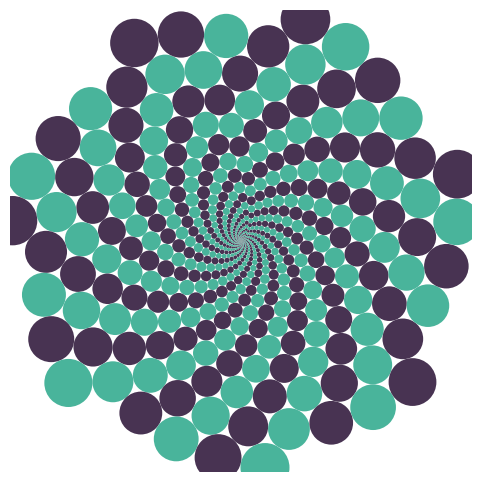

In [26]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import root

# ---------------------------------------------
# Doyle spiral math functions
# ---------------------------------------------

def d_(z, t, p, q):
    w = z ** (p / q)
    s = (p * t + 2 * np.pi) / q
    return (z * np.cos(t) - w * np.cos(s))**2 + (z * np.sin(t) - w * np.sin(s))**2

def s_(z, p, q):
    return (z + z ** (p / q)) ** 2

def r_(z, t, p, q):
    return d_(z, t, p, q) / s_(z, p, q)

def doyle(p, q):
    # Equations to find the root (z, t)
    def f_(x):
        z, t = x
        f1 = r_(z, t, 0, 1) - r_(z, t, p, q)
        f2 = r_(z, t, 0, 1) - r_(z ** (p / q), (p * t + 2 * np.pi) / q, 0, 1)
        return [f1, f2]

    sol = root(f_, [2.0, 0.0], tol=1e-6)
    if not sol.success:
        raise RuntimeError("Root finding did not converge")

    z, t = sol.x
    r = np.sqrt(r_(z, t, 0, 1))
    a = z * np.exp(1j * t)
    z2 = z ** (p / q)
    t2 = (p * t + 2 * np.pi) / q
    b = z2 * np.exp(1j * t2)

    return {
        "a": a,
        "b": b,
        "r": r,
        "mod_a": z,
        "arg_a": t
    }

# ---------------------------------------------
# Spiral drawing logic
# ---------------------------------------------

def draw_circle(ax, x, y, radius, color):
    circle = plt.Circle((x, y), radius, color=color, ec=color, lw=0)
    ax.add_artist(circle)

def spiral(ax, r, start_point, delta, opts, alpha, scale):
    mod_delta = abs(delta)
    colors = opts["fill"]
    min_d = opts["min_d"]
    max_d = opts["max_d"]
    w = np.exp(1j * alpha)

    color_index = opts["i"]
    q = start_point
    mod_q = abs(q)

    # spiral outwards
    while mod_q < max_d:
        col = colors[color_index - 1]
        center = scale * q * w
        draw_circle(ax, center.real, center.imag, r * scale * mod_q, col)
        color_index = 1 + (color_index % len(colors))
        q *= delta
        mod_q *= mod_delta

    # spiral inwards
    color_index = opts["i"] - 1 if opts["i"] > 1 else len(colors)
    q = start_point / delta
    mod_q = abs(q)
    while mod_q > min_d:
        col = colors[color_index - 1]
        center = scale * q * w
        draw_circle(ax, center.real, center.imag, r * scale * mod_q, col)
        color_index = color_index - 1 if color_index > 1 else len(colors)
        q /= delta
        mod_q /= mod_delta


# ---------------------------------------------
# Generate the Doyle spiral (2D)
# ---------------------------------------------
# 14 - 16
# 16 - 16
# 7 - 32
def frame(t, p=7, q=32, max_d=600):
    root = doyle(p, q)
    start = root["a"]
    scale = root["mod_a"] ** t
    alpha = root["arg_a"] * t
    min_d = 1 / scale

    fig, ax = plt.subplots(figsize=(6, 6))
    ax.set_aspect('equal')
    ax.axis('off')
    ax.set_xlim(-600, 600)
    ax.set_ylim(-600, 600)

    for i in range(1, q + 1):
        opts = {
            "fill": ["#49B49B", "#483352"],
            "i": 1 + (i % 2),
            "min_d": min_d,
            "max_d": max_d
        }
        spiral(ax, root["r"], start, root["a"], opts, alpha, scale)
        start *= root["b"]

    plt.show()


# Run
if __name__ == "__main__":
    frame(0)

